In [1]:
#Figure 6 graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [2]:
import tifffile
from matplotlib import pyplot as plt
import numpy as np
from skimage import filters, morphology, measure, segmentation
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
def im_stack_thresh(im_stack): 
    oats = []

    for i in range(len(im_stack)):
        oats.append(filters.threshold_otsu(im_stack[i]))

    return np.mean(oats)

In [4]:
def output_frame_bin(core_bin, cell_bin, log_tag): 
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.imshow(core_bin*1000 + cell_bin)
    fig.savefig('/Users/echo/Desktop/accumulation sandbox/2022_11_25_accumulation_analysis/bin_logs/' + str(log_tag) + '.png')
    plt.close(fig)

In [5]:
def frame_core_cell_count(frame, thresh, cell_bin, log_tag):
    #Threshold core by otsu thresh for stack, then remove all single cells etc
    bin_im = frame > thresh
    core_adj = morphology.erosion(bin_im)
    core_adj = morphology.remove_small_objects(core_adj, 20)
    core_adj = morphology.dilation(core_adj)
    
    #Calculate cells label by removing things counted in core
    cells = np.invert(core_adj)*cell_bin
    
    #Calculate the foreground by adding up core and cells, then calc background by taking median of all pixels not in 
    #foreground (background) 
    background_pixels = np.array(np.invert(core_adj + cells > 0) * frame).flatten()
    background = np.median(np.delete(background_pixels, np.where(background_pixels == 0)))
    
    #Integrate core by summing up pixels in the core area with the background subtracted off image. 
    core_sum = np.sum((frame - background)*core_adj)
    
    #Logging if interested in seeing what the image binarization scheme is doing under hood
    #if log_tag != '':
        #output_frame_bin(core_adj, cells, log_tag)
    
    #Label and get the properties of the cell labeled image with core removed
    cells_lbl = morphology.label(cells)
    cells_props = measure.regionprops(cells_lbl, intensity_image=frame)
    
    #Get the integrated intensity by taking cell intensity mean-background then multiplying by area
    nuc_int = []
    for j in range(len(cells_props)):
        #Take the average intensity of mean, subtract background and times by area
        int_calc = (cells_props[j].intensity_mean - background)*cells_props[j].area
        nuc_int.append(int_calc)
        
    #Get mean integrated intensity for a cell in frame
    nuc_mean = np.mean(nuc_int)
    
    #Devide integrated intensity of core by single cell mean
    return core_sum/nuc_mean


In [6]:
#Get the first calcium peak in an image, to help align when a swarm starts: 
def first_calcium_event(im):
    ca_means = [np.mean(frame) for frame in im]
    ca_peaks, _ = find_peaks(ca_means, prominence=1, width=15)

    if len(ca_peaks) == 0:
        return 0
    else:
        return min(ca_peaks)

In [7]:
def seg_to_mean_den(seg_im, px_size):
    nuclei_density = []
    for seg_page in seg_im:
        mm_sq = (px_size * seg_page.shape[0]) * (px_size * seg_page.shape[1])
        nuclei_density.append(seg_page.max()/mm_sq)
    return np.mean(nuclei_density)

In [8]:
def stack_to_core_accum(im_stack, seg_stack, im_tag=''):
    threshold = im_stack_thresh(im_stack)
    core_accum = []
    for i in range(len(im_stack)):
        if im_tag != '':
            log_tag = im_tag + '-' + str(i)
        else:
            log_tag = im_tag
        core_accum.append(frame_core_cell_count(im_stack[i], threshold, seg_stack[i], log_tag))

    return core_accum
    

In [9]:
def dic_yeast_to_area(target_im, im_tag=''):
    edges = filters.sobel(target_im) 
    bin_edges = edges > filters.threshold_otsu(edges)*1
    bin_edges = morphology.remove_small_holes(bin_edges, 10)
    return (1.1*1.1)*np.sum(bin_edges*1.)
    

In [10]:
#folder_path = '/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig4 - Accumulation Metrics/kinetic analysis'
folder_path = Path.cwd().parent / 'Data Sets' / 'Accumulation Sets' /'accumulation-kinetic'

analysis_folders = list(folder_path.glob('[!.]*'))


In [11]:
px_to_mm = 2.2/1000.0 #um/px --> mm/px

In [17]:

df_collect = []


for group in analysis_folders:
    volunteer_id = int(group.stem.split('-')[1][1:])
    nuclei_folder = group / 'nuclei'
    segmented_folder = nuclei_folder / 'segmented_nuclei'
    target_folder = group / 'targets'
    
    #Get all needed files in each folder:
    #Exclude hiddens
    nuclei_files = sorted(nuclei_folder.glob('[!.]*.tif'))
    seg_files = sorted(segmented_folder.glob('[!.]*.tif'))
    target_files = sorted(target_folder.glob("[!.]*.tif"))
    
    core_accums = []
    cell_density_measurements = []
    first_calcium_events = []
    target_areas = []
    labels = []

    for im_file_loc, seg_file_loc, target_file_loc in tqdm(list(zip(nuclei_files,seg_files,target_files))):
        im_file = tifffile.imread(im_file_loc)
        seg_file = tifffile.imread(seg_file_loc)
        target_file = tifffile.imread(target_file_loc)

        if im_file_loc.stem == target_file_loc.stem:
            labels.append(im_file_loc.stem)
            core_accums.append(stack_to_core_accum(im_file, seg_file))
            target_areas.append(dic_yeast_to_area(target_file))
            cell_density_measurements.append(seg_to_mean_den(seg_file, px_to_mm))
            first_calcium_events.append(first_calcium_event(im_file))
        else:
            print('label mismatch??')
            
            
    densitys = [int(dentlbl.split('m-')[0]) for dentlbl in labels]
    target_number = [int(dentlbl.split('m-')[-1]) for dentlbl in labels]
    
    df_col = []

    time_ar = np.array([j*5.0/60.0 for j in range(len(core_accums[0]))])
    first_calcium_events_in_time = [k*5.0/60.0 for k in first_calcium_events]
    

    for i in range(len(core_accums)):
        time_adj = time_ar - first_calcium_events_in_time[i] 
        df_single_file = pd.DataFrame({'label':labels[i], 'volunteer_id':volunteer_id, 'density':densitys[i], 'measured_density_mean':cell_density_measurements[i], 'target_size':target_areas[i], 'time':time_ar, 'first_ca_peak':first_calcium_events_in_time[i], 'adjusted_time':time_adj, 'accumulation':core_accums[i], 'accumulation-per-target':core_accums[i]/target_areas[i]})
        df_col.append(df_single_file)

    df_temp = pd.concat(df_col, ignore_index=True)
    df_collect.append(df_temp)
    
    

 18%|████████▎                                     | 2/11 [00:17<01:17,  8.59s/it]


KeyboardInterrupt: 

In [89]:
df_kinetic_accum = pd.concat(df_collect, ignore_index=True)

In [13]:
one_out = df_kinetic_accum[df_kinetic_accum['density'] != 6]

In [90]:

unique_ID_collect = []

for vid, density_group in df_kinetic_accum.groupby('volunteer_id'):
    for lid, label_group in density_group.groupby('label'):
        label_group['unique_ID'] = str(vid) + '-' + lid
        unique_ID_collect.append(label_group)

kinetic_accumulation_unique_ID_DF = pd.concat(unique_ID_collect, ignore_index=True)

In [127]:
kinetic_accumulation_unique_ID_DF.to_csv('fig6-supplement_accumulation_over_time.csv', index=False)

In [12]:
kinetic_accumulation_unique_ID_DF = pd.read_csv('fig6-supplement_accumulation_over_time.csv')

In [13]:
low_density_DF = kinetic_accumulation_unique_ID_DF[kinetic_accumulation_unique_ID_DF.measured_density_mean.between(2000,5000)]

high_density_DF = kinetic_accumulation_unique_ID_DF[kinetic_accumulation_unique_ID_DF.measured_density_mean.between(9000,12000)]


In [14]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})
colors = sns.color_palette('Purples',7)

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

Text(0, 0.5, '')

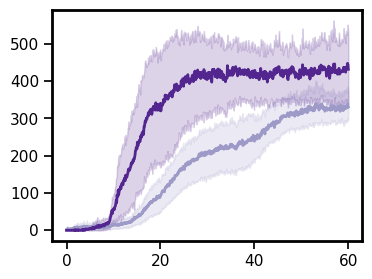

In [15]:
plt.figure(figsize=(4,3))
sns.lineplot(data=low_density_DF, x='time', y='accumulation', legend=False, color=colors[3])
sns.lineplot(data=high_density_DF, x='time', y='accumulation', legend=False, color=colors[6])
plt.xlabel('')
plt.ylabel('')
#plt.savefig('sup-fig4-accumulation-over-time.png', dpi=300, bbox_inches='tight')
#ax.legend(title="10^5 Cells in Well")
#plt.savefig('test.svg')


In [16]:
print('ROIs in Low Density Line: {}'.format(low_density_DF.unique_ID.nunique()))
print('ROIs in High Density Line: {}'.format(high_density_DF.unique_ID.nunique()))

ROIs in Low Density Line: 13
ROIs in High Density Line: 7


In [17]:
group = analysis_folders[0]

volunteer_id = int(group.stem.split('-')[1][1:])
nuclei_folder = group / 'nuclei'
segmented_folder = nuclei_folder / 'segmented_nuclei'
target_folder = group / 'targets'

#Get all needed files in each folder:
#Exclude hiddens
nuclei_files = sorted(nuclei_folder.glob('[!.]*.tif'))
seg_files = sorted(segmented_folder.glob('[!.]*.tif'))
target_files = sorted(target_folder.glob("[!.]*.tif"))


In [18]:
def stack_to_core_accum(im_stack, seg_stack, im_tag=''):
    
    core_accum = []
    for i in range(len(im_stack)):
        if im_tag != '':
            log_tag = im_tag + '-' + str(i)
        else:
            log_tag = im_tag
        core_accum.append(frame_core_cell_count(im_stack[i], threshold, seg_stack[i], log_tag))

    return core_accum

In [54]:
export_location = Path.cwd() / 'accumulation-stills' / '8-3m-1' 
vmin_set = 450
vmax_set = 850
crop_buffer = 50 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10


In [55]:
t_subsample = [60, 144, 288, 432, 576, 720] #Sample 5 times, every 12min

In [56]:
im_file_loc = Path.cwd().parent / 'Data Sets' / 'Accumulation Sets' / 'accumulation-kinetic' / '1210-v8' / 'nuclei' / '3m-1.tif'

In [57]:
#Generating stills with boundry of accumulation overlay on nuclear imaging:
im_file = tifffile.imread(im_file_loc) #0: 8-10m-1, 6: 3m-3

#Get the final core centroid first:

threshold = im_stack_thresh(im_file)

frame = im_file[-1]

#Threshold core by otsu thresh for stack, then remove all single cells etc
bin_im = frame > threshold
core_adj = morphology.erosion(bin_im)
core_adj = morphology.remove_small_objects(core_adj, 20)
core_adj = morphology.dilation(core_adj)

#Get the info of the cores detected: 
core_infos = pd.DataFrame(measure.regionprops_table(measure.label(core_adj), properties=['area','centroid']))

#If there are two, take the bigger one as the center one: 
if len(core_infos) > 1: 
    max_idx = core_infos.area.idxmax()
    max_core = core_infos.loc[max_idx]
    core_center = [int(max_core['centroid-1']),int(max_core['centroid-0'])]
else: 
    core_center = [int(core_infos['centroid-1'].values),int(core_infos['centroid-0'].values)]

for t, frame in enumerate(im_file):
    if t in t_subsample:
        #Threshold core by otsu thresh for stack, then remove all single cells etc
        bin_im = frame > threshold
        core_adj = morphology.erosion(bin_im)
        core_adj = morphology.remove_small_objects(core_adj, 20)
        core_adj = morphology.dilation(core_adj)
        boundary_core = measure.find_contours(core_adj)

        #Plotting
        fig, ax = plt.subplots(figsize=(10,10))
        plt.imshow(frame, cmap='Greys_r', vmin=vmin_set,vmax=vmax_set)
        plt.axis('off')
        for contour in boundary_core:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=4, color='red')

        plt.ylim(core_center[1]-crop_buffer,core_center[1]+crop_buffer)
        plt.xlim(core_center[0]-crop_buffer,core_center[0]+crop_buffer)
        plt.gca().invert_yaxis()

        scalebar = AnchoredSizeBar(ax.transData,
                                   100/2.2, '',  'upper right', 
                                   pad=1,
                                   color='white',
                                   frameon=False,
                                   size_vertical=5)

        ax.add_artist(scalebar)
        plt.savefig(export_location / Path('v8_' + im_file_loc.stem + '-{}.png'.format(t)), dpi=300, bbox_inches='tight')
        plt.close()
